In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns

In [2]:
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

In [3]:
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [4]:
from sklearn.decomposition import PCA

In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import shap

In [ ]:
path = '/home/aurore/Documents/HoursDoc/Formations/DESU_DataScience/MachineLearning/'

raw_df = pd.read_csv(path + 'personality_synthetic_dataset.csv')
#raw_df.drop("Id",axis='columns',inplace=True) # inplace = True -> met à jour, pas besoin de faire raw_df = raw_df.drop(..)
print(raw_df.shape)
raw_df.head()

(2900, 8)


,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,4.0,No,4.0,6.0,No,13.0,5.0,Extrovert
1,9.0,Yes,0.0,0.0,Yes,0.0,3.0,Introvert
2,9.0,Yes,1.0,2.0,Yes,5.0,2.0,Introvert
3,0.0,No,6.0,7.0,No,14.0,8.0,Extrovert
4,3.0,No,9.0,4.0,No,8.0,5.0,Extrovert


# Pas de doublons  
pass

# Valeurs nulles

In [7]:
# copie du dataframe
df = raw_df.copy()
var_nan = df.isnull().sum() * 100 / len(df)
var_nan.sort_values(ascending=False, inplace=True)
var_nan

Friends_circle_size          2.655172
Stage_fear                   2.517241
Going_outside                2.275862
Post_frequency               2.241379
Time_spent_Alone             2.172414
Social_event_attendance      2.137931
Drained_after_socializing    1.793103
Personality                  0.000000
dtype: float64

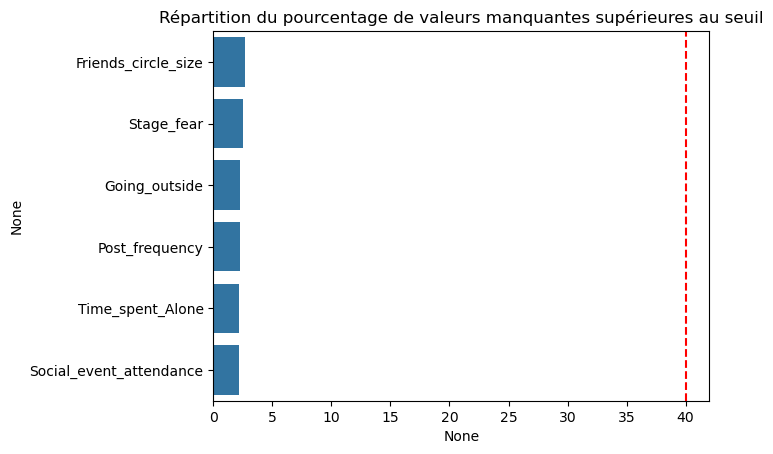

In [8]:
thr_view = 2

filtered = var_nan[var_nan.values > thr_view]
ax = sns.barplot(x = filtered, y = filtered.index, orient = 'h')
ax.set_title(f"Répartition du pourcentage de valeurs manquantes supérieures au seuil")

thr = 40
ax.axvline(x= thr, color='r', linestyle='--', label = f"Seuil de {thr}")

### Imputer les valeurs nulles (car pas bcp)

In [9]:
# Numériques
numeric_features = df.select_dtypes(include=['float', 'int']) # ne garde que les variables numériques
imputation = KNNImputer(missing_values=np.nan)
imputed = imputation.fit_transform(df.loc[:,numeric_features.columns].values)

df.loc[:,numeric_features.columns] = imputed

In [10]:
# Catégoriques
cat_features = df.select_dtypes(exclude=['float', 'int'])

imp_mean = SimpleImputer(missing_values=np.nan, strategy='most_frequent') # on a des variables catégorielles, mean ne peut pas marcher par exemple
imp = imp_mean.fit_transform(df.loc[:,cat_features.columns].values) # sur une varaible catégorielle

df.loc[:,cat_features.columns] = imp

In [11]:
# Pour vérifier
var_nan = df.isnull().sum() * 100 / len(df)
var_nan.sort_values(ascending=False, inplace=True)
var_nan

Time_spent_Alone             0.0
Stage_fear                   0.0
Social_event_attendance      0.0
Going_outside                0.0
Drained_after_socializing    0.0
Friends_circle_size          0.0
Post_frequency               0.0
Personality                  0.0
dtype: float64

#### Effet de mon imputation

In [12]:
list(cat_features.columns)

['Stage_fear', 'Drained_after_socializing', 'Personality']

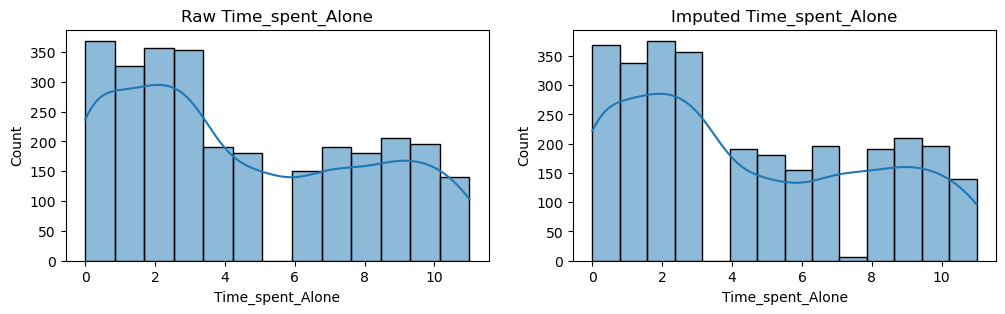

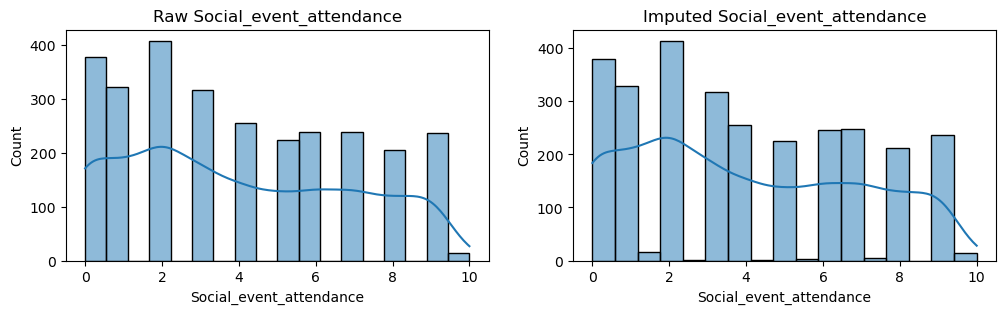

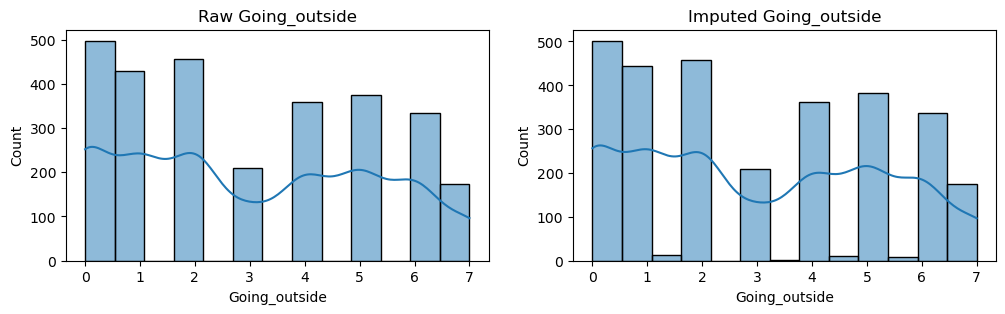

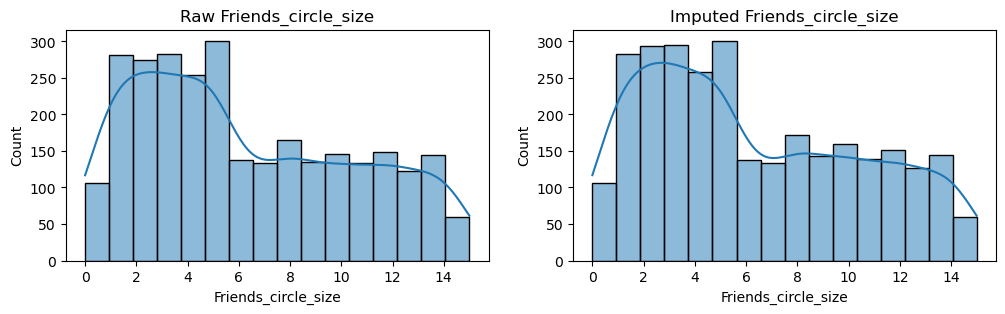

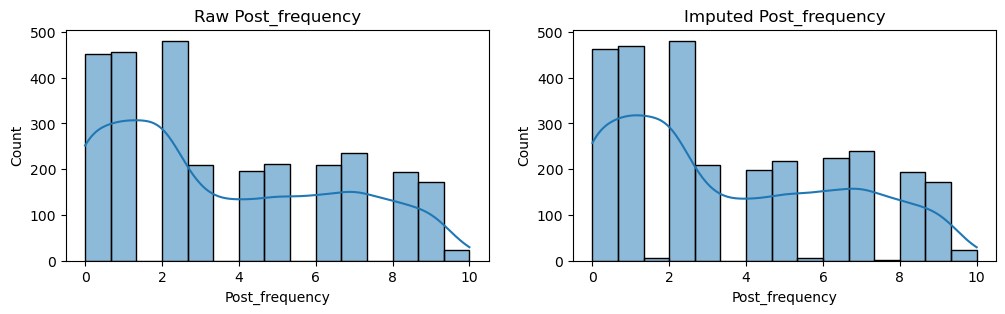

In [13]:
def compare_dist(feature):
    fig, axes = plt.subplots(1,2,figsize=(12,3))
    sns.histplot(raw_df.loc[:,feature],kde=True, ax=axes[0])
    axes[0].set_title(f"Raw {feature}");

    sns.histplot(df.loc[:,feature],kde=True, ax=axes[1])
    axes[1].set_title(f"Imputed {feature}")

# Sur les valeurs numériques
for i in list(numeric_features.columns) :
    compare_dist(i)

# Outliers

Critère de Tuckey (convention)

Text(0.5, 1.0, 'Boxplots utilisant le critère de Tukey')

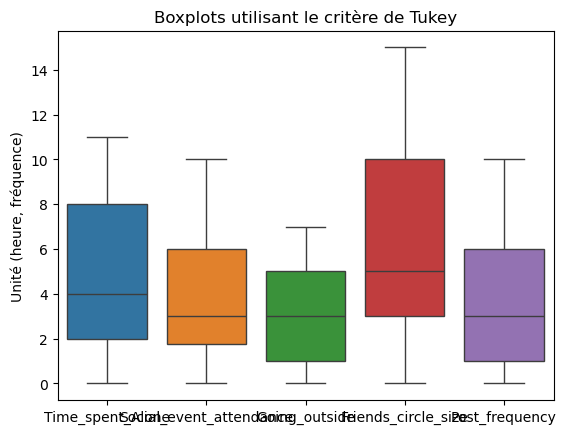

In [14]:
ax = sns.boxplot(data=df)
ax.set_ylabel("Unité (heure, fréquence)")
ax.set_title("Boxplots utilisant le critère de Tukey")

A priori, pas d'outliers  
Scatter Plot (pas utile ici)

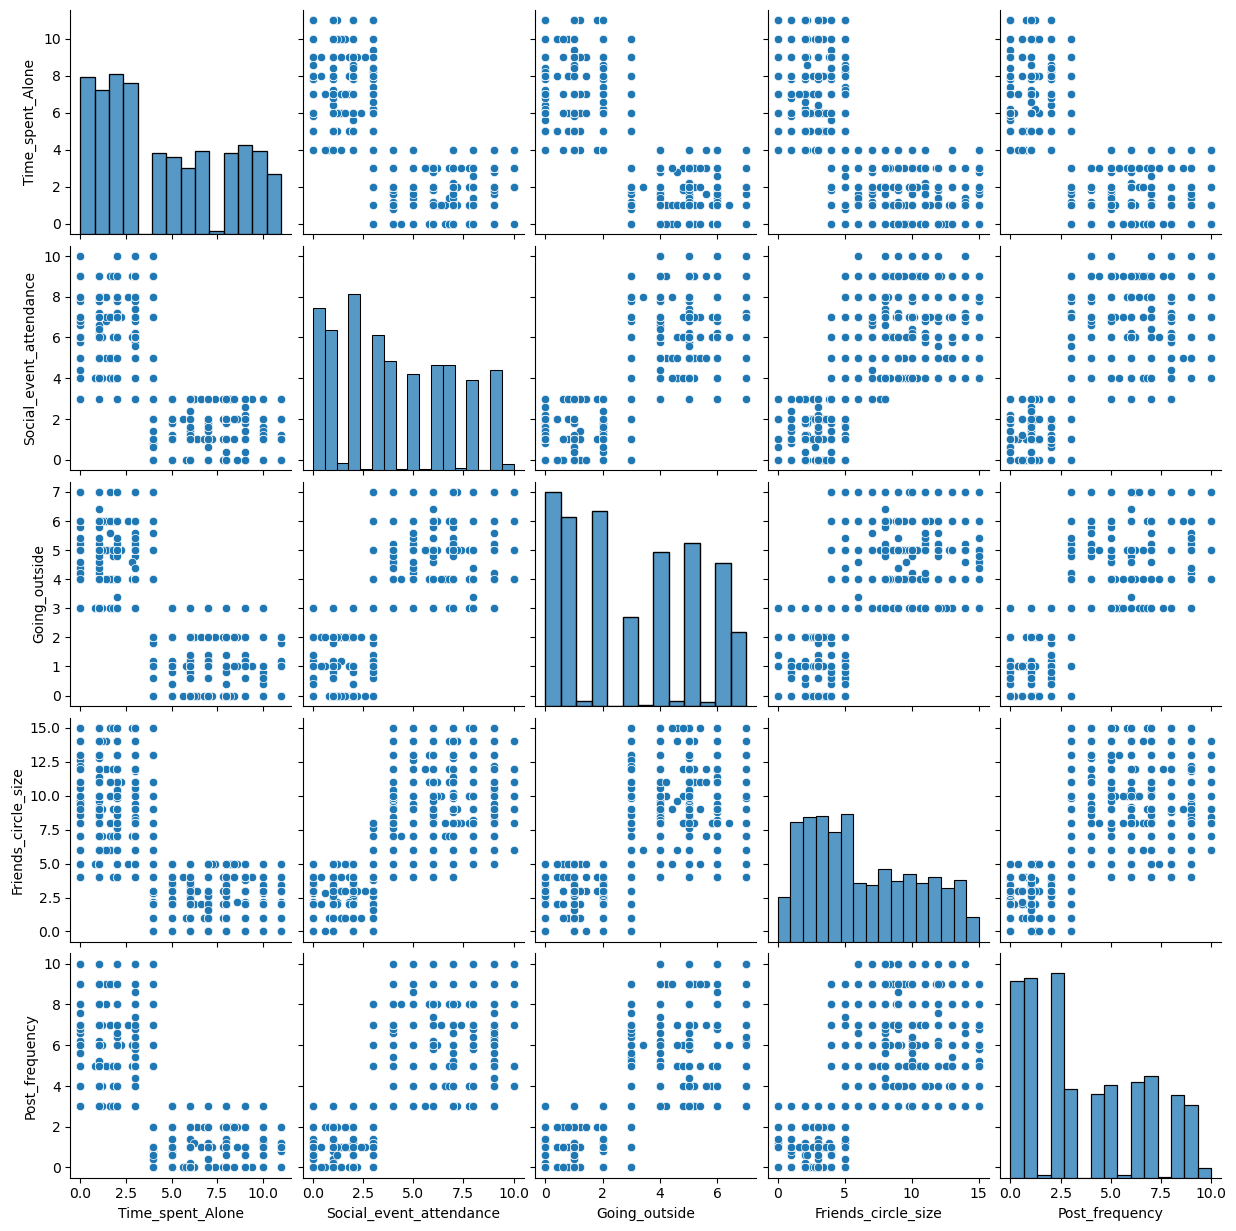

In [15]:
sns.pairplot(df)

# Encodage des valeurs catégorielles

Ma variable prédictive, pas dans les données d'entraînement : mon y

In [16]:
le = preprocessing.LabelEncoder()
y=le.fit_transform(df['Personality'])

y

array([0, 1, 1, ..., 1, 1, 0])

Mes autres variables catégorielles  
/!\ Ne sont pas ordinales 

In [17]:
df.select_dtypes('object').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Stage_fear                 2900 non-null   object
 1   Drained_after_socializing  2900 non-null   object
 2   Personality                2900 non-null   object
dtypes: object(3)
memory usage: 68.1+ KB


In [18]:
enc = OneHotEncoder(handle_unknown='ignore')
encoded_features = enc.fit_transform(df.loc[:,['Stage_fear','Drained_after_socializing']]).toarray()


In [19]:
encoded_features

array([[1., 0., 1., 0.],
       [0., 1., 0., 1.],
       [0., 1., 0., 1.],
       ...,
       [0., 1., 0., 1.],
       [0., 1., 0., 1.],
       [1., 0., 1., 0.]])

In [20]:
df_encoded = df.copy()
df_encoded.drop(['Stage_fear','Drained_after_socializing','Personality'], axis = 1)

# Création des noms de colonnes encodées
encoded_col_names = enc.get_feature_names_out(['Stage_fear', 'Drained_after_socializing'])

# Conversion en DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoded_col_names, index=df.index)

# Création de df_encoded en supprimant les colonnes originales
df_encoded = df.drop(['Stage_fear', 'Drained_after_socializing', 'Personality'], axis=1)

# Ajout des colonnes encodées
df_encoded = pd.concat([df_encoded, encoded_df], axis=1)

# Affichage
df_encoded.head()


,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency,Stage_fear_No,Stage_fear_Yes,Drained_after_socializing_No,Drained_after_socializing_Yes
0,4.0,4.0,6.0,13.0,5.0,1.0,0.0,1.0,0.0
1,9.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,1.0
2,9.0,1.0,2.0,5.0,2.0,0.0,1.0,0.0,1.0
3,0.0,6.0,7.0,14.0,8.0,1.0,0.0,1.0,0.0
4,3.0,9.0,4.0,8.0,5.0,1.0,0.0,1.0,0.0


# Scaling des données numériques

Je vérifie si mes classes sont fortement déséquilibrées ou non  
C'est ok

In [21]:
y.sum() # nb d'introvertis

1409

Je n'ai pas d'outliers, j'applique donc une standardisation classique

In [22]:
features_idx = df_encoded.loc[:,numeric_features.columns].index
X = df_encoded.loc[:,numeric_features.columns].values
original_data = X
original_df = pd.DataFrame(original_data, columns=numeric_features.columns)

standard_data = StandardScaler().fit_transform(X)
standard_df = pd.DataFrame(standard_data, columns=numeric_features.columns)

df_last = pd.concat([standard_df, encoded_df], axis=1)
df_last.head()

,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency,Stage_fear_No,Stage_fear_Yes,Drained_after_socializing_No,Drained_after_socializing_Yes
0,-0.145028,0.013630,1.337109,1.575105,0.491082,1.0,0.0,1.0,0.0
1,1.295910,-1.365997,-1.337847,-1.468350,-0.193698,0.0,1.0,0.0,1.0
2,1.295910,-1.021090,-0.446195,-0.297790,-0.536088,0.0,1.0,0.0,1.0
3,-1.297778,0.703443,1.782935,1.809217,1.518251,1.0,0.0,1.0,0.0
4,-0.433215,1.738163,0.445457,0.404545,0.491082,1.0,0.0,1.0,0.0


# Voyons si certaines variables sont corrélées 

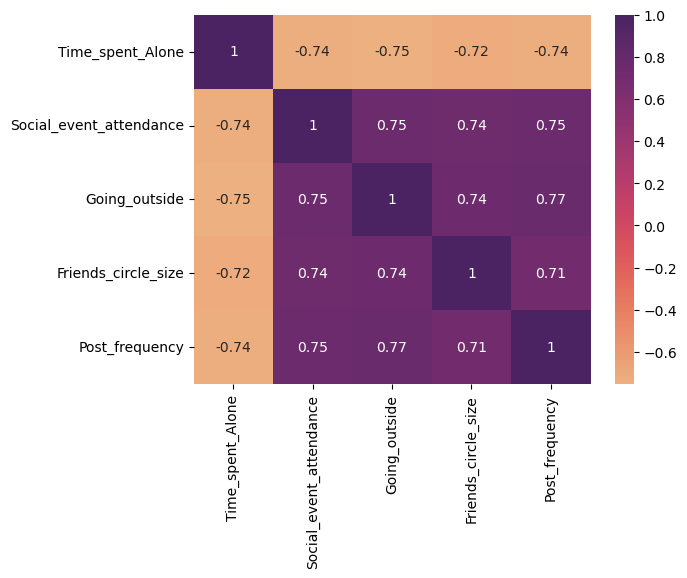

In [23]:
sns.heatmap(df_last.loc[:,numeric_features.columns].corr(), annot=True, cmap='flare')
plt.show()

# Faisons une ACP

In [24]:
# PCA complète
pca = PCA()
X_pca = pca.fit_transform(df_last)

# Créer les noms des composantes
pc_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]

# Construire le DataFrame avec toutes les composantes + species
df_pca_full = pd.DataFrame(X_pca, columns=pc_names)
df_pca_full['Personality'] = y

# Ajouter les variances expliquées (en %)
explained_variance = pca.explained_variance_ratio_
variance_df = pd.DataFrame({
    "PC": pc_names,
    "Explained Variance (%)": explained_variance * 100
})

# Afficher les variances expliquées
display(variance_df)

,PC,Explained Variance (%)
0,PC1,8.120765e+01
1,PC2,4.935306e+00
2,PC3,4.480503e+00
3,PC4,4.193794e+00
4,PC5,3.699441e+00
5,PC6,1.121833e+00
6,PC7,3.614709e-01
7,PC8,1.876819e-30
8,PC9,3.842548e-32


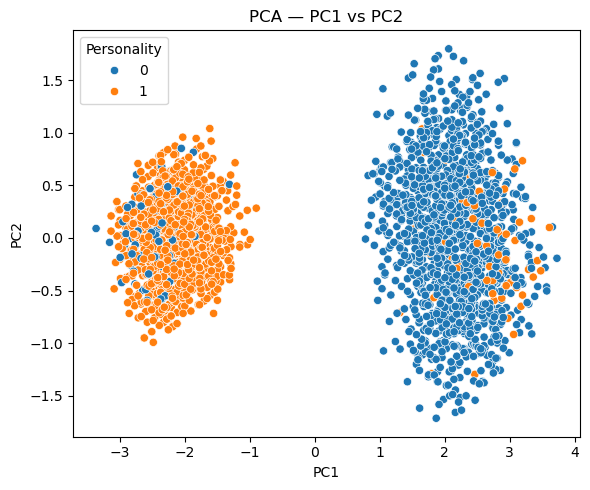

In [25]:
plt.figure(figsize=(6,5))
sns.scatterplot(data=df_pca_full, x='PC1', y='PC2', hue='Personality')
plt.title("PCA — PC1 vs PC2")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()


# Pipeline pour standardiser et réaliser une classification KNN

In [26]:
pipeline = make_pipeline(StandardScaler(),KNeighborsClassifier()) # On aurait pu prendre une régression logistique, plus simple et binaire
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
pipeline.fit(X_train,y_train)
pipeline.score(X_test,y_test)

0.9195402298850575

In [27]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [30]:
shap.initjs()

In [31]:
explainer = shap.KernelExplainer(pipeline.predict_proba, X_train)
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value[0], shap_values[..., 0], X_test)

Using 1943 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/957 [00:00<?, ?it/s]